In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from fredapi import Fred
from scipy.interpolate import interp1d
from scipy.stats import zscore
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
from statsmodels.tsa.holtwinters import ExponentialSmoothing



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11208\3193089746.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Define function to fetch FRED data
def fetch_fred_data(api_key, series_id):
    fred = Fred(api_key=api_key)
    data = fred.get_series(series_id)
    df = pd.DataFrame({'date': data.index, 'value': data.values})
    return df

# Fetch ICNSA data using FRED API
FRED_API_KEY = '360481124fc765b815de2697f1bf8d62'
icnsa = fetch_fred_data(api_key=FRED_API_KEY, series_id='ICNSA')

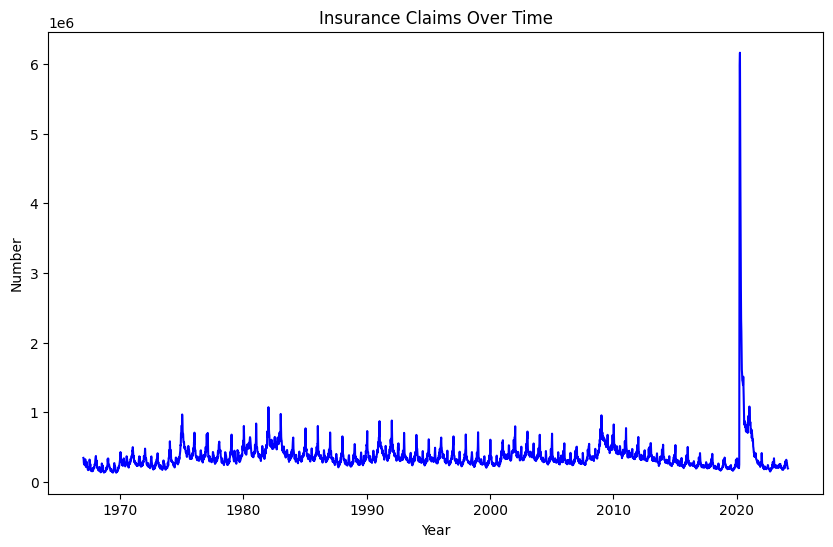

In [4]:
# Plot ICNSA over time
plt.figure(figsize=(10, 6))
plt.plot(icnsa["date"], icnsa["value"], color="blue")
plt.title("Insurance Claims Over Time")
plt.xlabel("Year")
plt.ylabel("Number")
plt.show()

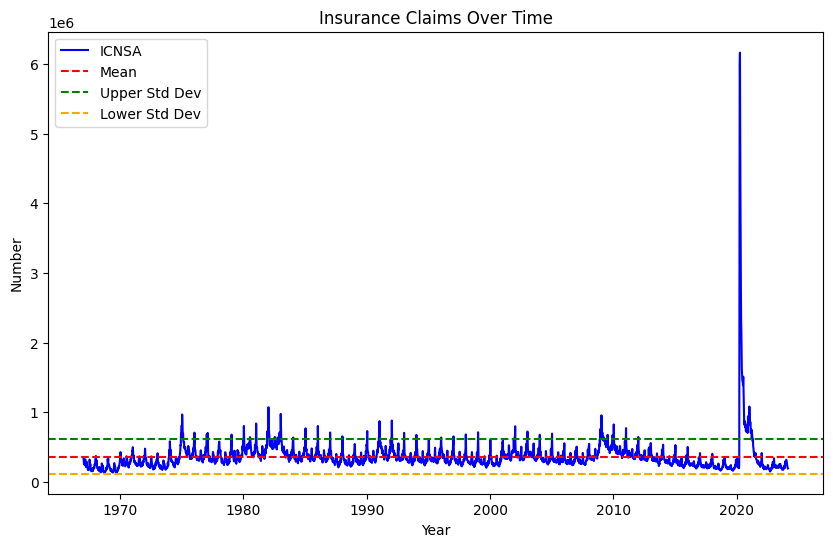

In [5]:
# Calculate the mean and standard deviation of the 'value' column
mean_value = icnsa['value'].mean()
std_value = icnsa['value'].std()

# Calculate upper and lower bounds (mean +/- 1 standard deviation)
upper_bound = mean_value + std_value
lower_bound = mean_value - std_value

# Plot ICNSA over time with mean, upper bound, and lower bound
plt.figure(figsize=(10, 6))
plt.plot(icnsa["date"], icnsa["value"], color="blue", label="ICNSA")
plt.axhline(y=mean_value, linestyle="--", color="red", label="Mean")
plt.axhline(y=upper_bound, linestyle="--", color="green", label="Upper Std Dev")
plt.axhline(y=lower_bound, linestyle="--", color="orange", label="Lower Std Dev")
plt.title("Insurance Claims Over Time")
plt.xlabel("Year")
plt.ylabel("Number")
plt.legend()
plt.show()

Detected anomalies:
           date      value    z_score
2776 2020-03-21  2914268.0  10.065646
2777 2020-03-28  5981838.0  22.177306
2778 2020-04-04  6161268.0  22.885748
2779 2020-04-11  4898119.0  17.898468
2780 2020-04-18  4221704.0  15.227785
2781 2020-04-25  3466665.0  12.246671
2782 2020-05-02  2790860.0   9.578396
2783 2020-05-09  2325889.0   7.742555
2784 2020-05-16  2162822.0   7.098719
2785 2020-05-23  1902006.0   6.068941
2786 2020-05-30  1610909.0   4.919605
2787 2020-06-06  1555824.0   4.702114
2788 2020-06-13  1456353.0   4.309373
2789 2020-06-20  1446176.0   4.269192
2790 2020-06-27  1425969.0   4.189408
2791 2020-07-04  1390315.0   4.048636
2792 2020-07-11  1511632.0   4.527631
2793 2020-07-18  1372247.0   3.977298
2794 2020-07-25  1200962.0   3.301015


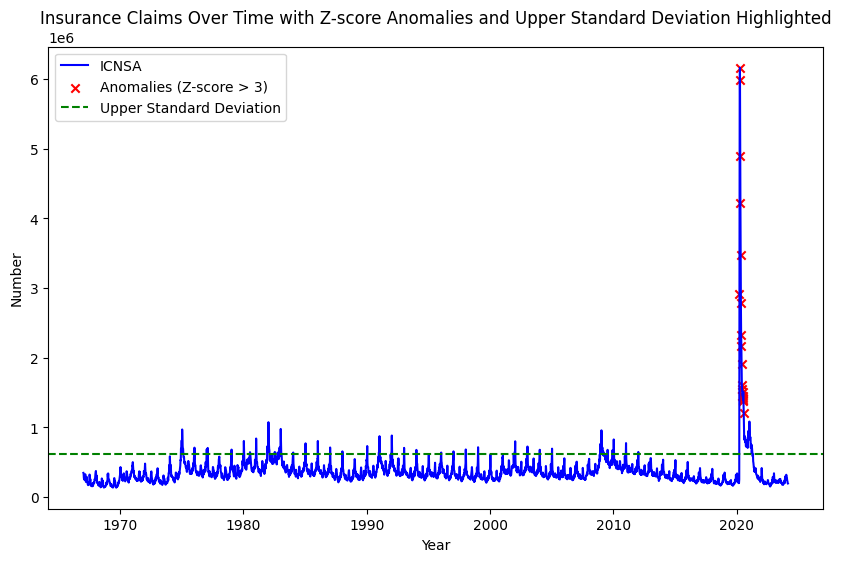

In [6]:
# Calculate Z-score for anomaly detection
icnsa["z_score"] = zscore(icnsa["value"])
threshold = 3
anomalies = icnsa[abs(icnsa["z_score"]) > threshold]
print("Detected anomalies:")
print(anomalies)

# Plot data with anomalies highlighted
plt.figure(figsize=(10, 6))
plt.plot(icnsa["date"], icnsa["value"], color="blue", label="ICNSA")
plt.scatter(anomalies["date"], anomalies["value"], color="red", marker="x", label="Anomalies (Z-score > 3)")
plt.axhline(y=upper_bound, linestyle="--", color="green", label="Upper Standard Deviation")
plt.title("Insurance Claims Over Time with Z-score Anomalies and Upper Standard Deviation Highlighted")
plt.xlabel("Year")
plt.ylabel("Number")
plt.legend()
plt.show()

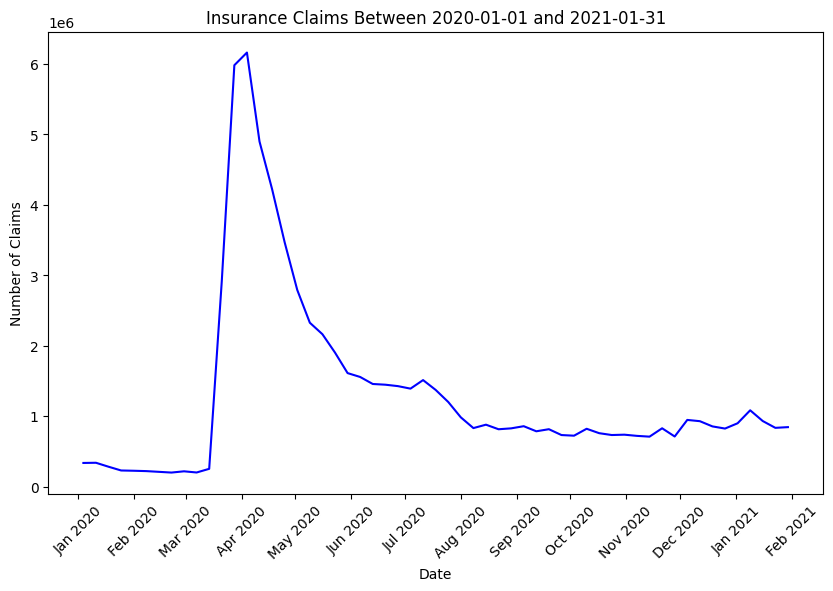

In [7]:
# Define the start and end dates
start_date = '2020-01-01'
end_date = '2021-01-31'

# Convert date columns to datetime
icnsa['date'] = pd.to_datetime(icnsa['date'])

# Filter data between the given dates
filtered_data = icnsa[(icnsa['date'] >= start_date) & (icnsa['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['date'], filtered_data['value'], color="blue")
plt.title("Insurance Claims Between {} and {}".format(start_date, end_date))
plt.xlabel("Date")
plt.ylabel("Number of Claims")

# Set custom date format for x-axis
date_format = mdates.DateFormatter('%b %Y')
plt.gca().xaxis.set_major_formatter(date_format)

# Ensure ticks are set for every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()


In [8]:
#(Start date: 2020-03-07, End date: 2021-07-31)

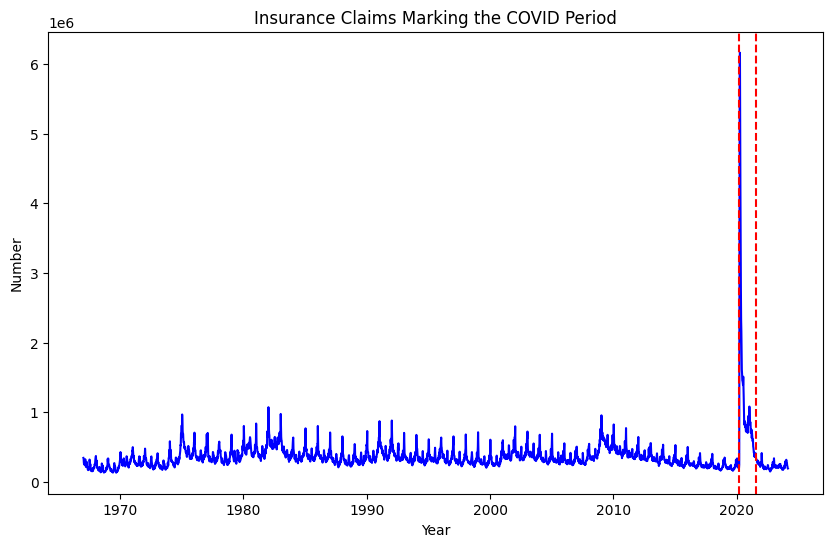

In [9]:
# Define COVID period
start_date = pd.to_datetime("2020-03-07")
end_date = pd.to_datetime("2021-07-31")
covid_period = icnsa[(icnsa["date"] >= start_date) & (icnsa["date"] <= end_date)]

# Plot COVID period
plt.figure(figsize=(10, 6))
plt.plot(icnsa["date"], icnsa["value"], color="blue")
plt.axvline(x=start_date, color="red", linestyle="--")
plt.axvline(x=end_date, color="red", linestyle="--")
plt.title("Insurance Claims Marking the COVID Period")
plt.xlabel("Year")
plt.ylabel("Number")
plt.show()

In [12]:
import pandas as pd

# Define non-COVID and COVID periods
start_date = '2020-03-07'
end_date = '2021-07-31'

non_covid_period = icnsa[(icnsa['date'] < start_date) | (icnsa['date'] > end_date)]
covid_period = icnsa[(icnsa['date'] >= start_date) & (icnsa['date'] <= end_date)]

# Try different spar values  
lambda_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Initialize an empty list to store updated data frames for each spar value
updated_data_list = []

# Initialize an empty DataFrame to store lambda and MSE values
lambda_mse_df = pd.DataFrame(columns=['lambda', 'MSE'])

for lam in lambda_values:
    # Fit spline 
    spline_fit = CubicSpline(non_covid_period['date'], non_covid_period['value'])
  
    # Impute values
    imputed = spline_fit(covid_period['date'])
    covid_period['value'] = imputed
  
    # Combine and sort
    updated_icnsa = pd.concat([non_covid_period, covid_period]).sort_values('date')
  
    # Store updated data
    updated_data_list.append(updated_icnsa)
  
    # Calculate MSE
    mse = ((updated_icnsa['value'] - icnsa['value']) ** 2).mean()
  
    # Append lambda and MSE values to the DataFrame
    lambda_mse_df = pd.concat([lambda_mse_df, pd.DataFrame({'lambda': [lam], 'MSE': [mse]})], ignore_index=True)

print(lambda_mse_df)


   lambda           MSE
0     0.1  4.755160e+10
1     0.2  4.755160e+10
2     0.3  4.755160e+10
3     0.4  4.755160e+10
4     0.5  4.755160e+10
5     0.6  4.755160e+10
6     0.7  4.755160e+10
7     0.8  4.755160e+10
8     0.9  4.755160e+10
9     1.0  4.755160e+10


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11208\3975037700.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_period['value'] = imputed
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11208\3975037700.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lambda_mse_df = pd.concat([lambda_mse_df, pd.DataFrame({'lambda': [lam], 'MSE': [mse]})], ignore_index=True)


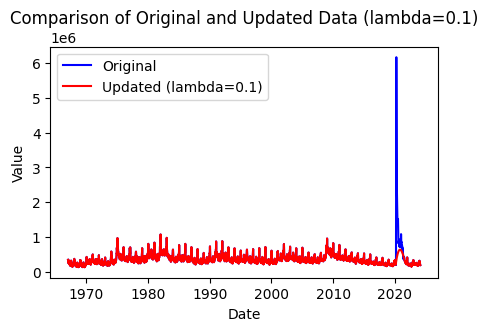

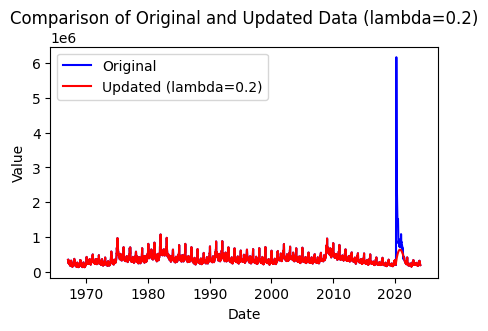

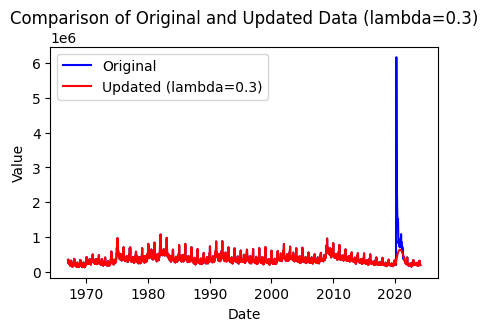

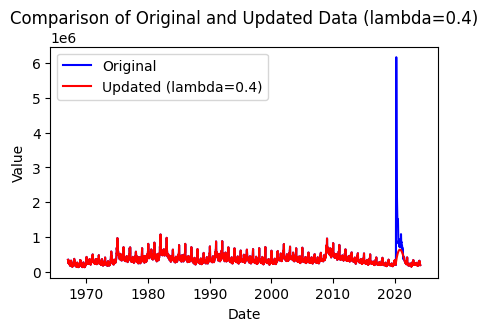

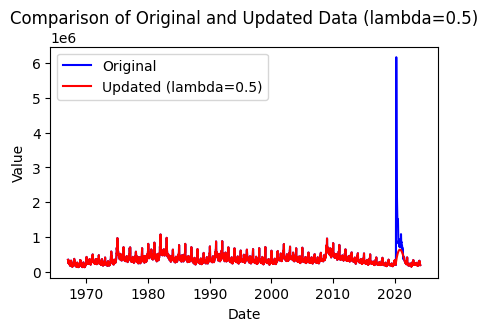

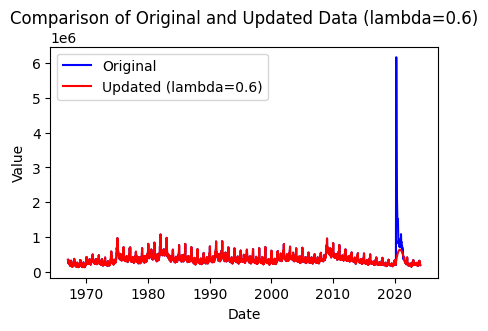

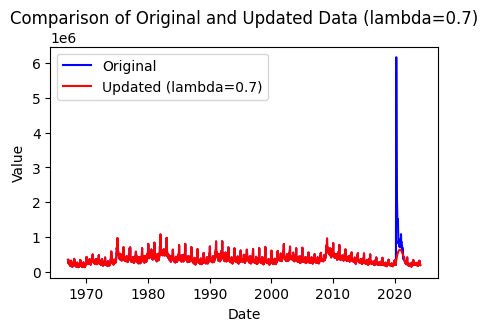

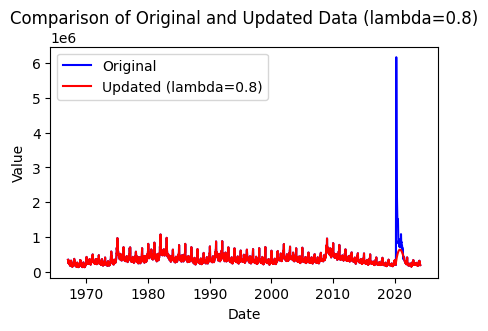

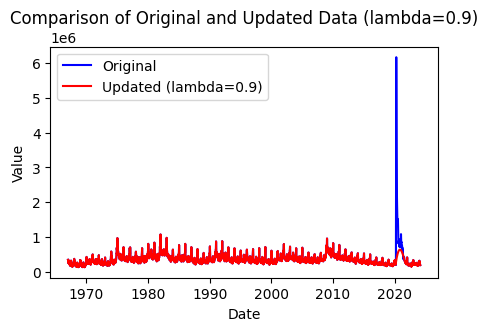

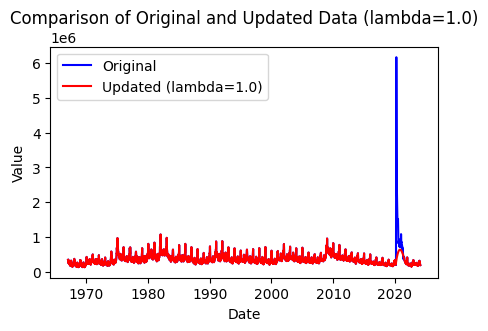

In [13]:
import matplotlib.pyplot as plt

# Plot updated data for each lambda value
for i, updated_data in enumerate(updated_data_list):
    plt.figure(figsize=(5, 3))
    plt.plot(icnsa['date'], icnsa['value'], color='blue', label='Original')
    plt.plot(updated_data['date'], updated_data['value'], color='red', label=f'Updated (lambda={lambda_values[i]})')
    plt.title(f'Comparison of Original and Updated Data (lambda={lambda_values[i]})')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


In [22]:
import numpy as np

# Initialize empty lists to store AIC and BIC values
aic_values = []
bic_values = []

# Calculate AIC and BIC for the current model
residuals = covid_period['value'] - imputed
rss = np.sum(residuals**2)
n = len(covid_period['value'])
k = 3  # Number of parameters in the model (intercept, lambda, and degree of freedom)
aic_values.append(n * np.log(rss / n) + 2 * k)
bic_values.append(n * np.log(rss / n) + k * np.log(n))

# Find the index of the minimum AIC and BIC values
min_aic_index = np.argmin(aic_values)
min_bic_index = np.argmin(bic_values)

# Get the corresponding lambda values
best_lambda_aic = lambda_values[min_aic_index]
best_lambda_bic = lambda_values[min_bic_index]

# Print the lambda values corresponding to the minimum AIC and BIC
print("Lambda value corresponding to minimum AIC:", best_lambda_aic)
print("Lambda value corresponding to minimum BIC:", best_lambda_bic)


Lambda value corresponding to minimum AIC: 0.1
Lambda value corresponding to minimum BIC: 0.1


In [23]:
non_covid_period = icnsa[(icnsa['date'] < start_date) | (icnsa['date'] > end_date)]
covid_period = icnsa[(icnsa['date'] >= start_date) & (icnsa['date'] <= end_date)]

# Initialize lists to store results
updated_data_list = []
lambda_mse_df = pd.DataFrame(columns=['lambda', 'MSE'])

In [18]:
# Apply Holt-Winters models
icnsa_ts = pd.Series(imputed, index=covid_period["date"]).resample("W").mean().interpolate()

seasonal_periods = 4  # Assuming weekly data, so seasonal cycle repeats every 4 weeks

# Apply Holt-Winters models
hw_add = ExponentialSmoothing(icnsa_ts, seasonal="additive", seasonal_periods=seasonal_periods, initialization_method="estimated").fit()
hw_mult = ExponentialSmoothing(icnsa_ts, seasonal="multiplicative", seasonal_periods=seasonal_periods, initialization_method="estimated").fit()

# Forecast next values
forecast_add = hw_add.forecast(1)
forecast_mult = hw_mult.forecast(1)

print("Forecasted Insurance Claims using Holt-Winters Additive Model:", forecast_add)
print("Forecasted Insurance Claims using Holt-Winters Multiplicative Model:", forecast_mult)


Forecasted Insurance Claims using Holt-Winters Additive Model: 2021-08-08    336880.764892
Freq: W-SUN, dtype: float64
Forecasted Insurance Claims using Holt-Winters Multiplicative Model: 2021-08-08    336926.422607
Freq: W-SUN, dtype: float64


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
